In [1]:
import pandas as pd
import numpy as np

import scipy.io as sio
from mat4py import loadmat

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

import math

# Criando os métodos

In [2]:
def geraDatas(iniPessoas = 1, qtdPessoas = 1):
    #Pegandos os dados
    datas = []
    
    for i in range(iniPessoas, iniPessoas + qtdPessoas):
        try:
            datas.append((loadmat(str(i).zfill(2) + "_session1.mat"), loadmat(str(i).zfill(2) + "_session2.mat")))
        except:
            print("Arquivo " + str(i).zfill(2) + " não existe")
        
    return datas

In [38]:
def geraDf(datas, vRange = None, cols = [], frac=1):    
    eletrodos = ["F3", "F4", "AF3", "AF4", "C5", "C6", "C3", "C4", "C1", "C2", "P3", "P4", "P5", "P6", "Fz", "Cz"]
    
    #Encontrando os dados
    lisRes = []
    lisCon = []
    
    for pessoa in datas:
        try:
            lisRes.append(pd.DataFrame(pessoa[0]["dataBeforeSession"], columns = eletrodos))
            #lisRes.append(pd.DataFrame(pessoa[0]["dataAfterSession"], columns = eletrodos))
            lisRes.append(pd.DataFrame(pessoa[1]["dataBeforeSession"], columns = eletrodos)) 
            #lisRes.append(pd.DataFrame(pessoa[1]["dataAfterSession"], columns = eletrodos))

            #lisCon.append(calcMediaDf(pd.DataFrame(pessoa[0]["dataDuringSession"], columns = eletrodos), 0.5))
            
        except:
            print("Erro na Pessoa " + str(pessoa[2]).zfill(2))
        
    #Gerando os dfs separados
    dfRes = pd.concat(lisRes)
    #dfCon = pd.concat(lisCon)
        
    if vRange != None:
        dfRes = dfRes[(dfRes[:] < vRange) & (dfRes[:] > -vRange)].dropna()
        #dfCon = dfCon[(dfCon[:] < vRange) & (dfCon[:] > -vRange)].dropna()
        
    #Classificando os dfs
    dfRes['State'] = 0 #Relaxado
    #dfCon['State'] = 1 #Concentrado
    
    #Juntando os dfs
    #df = pd.concat([dfRes, dfCon])
    df = dfRes
    
    for col in cols:
        del df[col]
    
    df = calcMediaDf(df, frac)
    df = df.sample(frac=1, random_state = 666).reset_index(drop=True)
    df = df.astype({"State": int})
    
    return df

In [4]:
def testeEspecificidade(modelo, iniPessoas = 1, qtdPessoas = 1, vRange = None, cols = []):
    df = geraDf(geraDatas(iniPessoas, qtdPessoas), vRange, cols)
    testePrecisao(modelo, df.drop('State',axis=1), df['State'])

In [5]:
def testePrecisao(modelo, df_x, df_y):
    predict = modelo.predict(df_x)
    print(classification_report(df_y, predict))

In [6]:
def calcMediaDf(df, frac):
    tamanhoTotal = len(df.index)
    
    print(str(tamanhoTotal) + " e " + str(tamanhoTotal * frac))
    
    nElems = tamanhoTotal * frac
    divisao = int(tamanhoTotal/nElems)
    
    return df.groupby(np.arange(len(df))//divisao).mean()

In [7]:
def geraModeloML(iniPessoas = 1, qtdPessoas = 1, n = 50, vRange = None, cols = [], frac=1):
    #Pegandos os dados
    datas = geraDatas(iniPessoas, qtdPessoas)
    print("Dados coletados")
        
    #Criando o df
    df = geraDf(datas, vRange, cols, frac)
    print("---------------")
    print("DataFrame criado")
    print("---------------")
    
    #Dividindo os dados
    x_train, x_test, y_train, y_test = train_test_split(df.drop('State',axis=1), 
                                                    df['State'], test_size=0.20, random_state = 666)
        
    #Treinando
    modelo = RandomForestClassifier(n_estimators = n,verbose = 2, n_jobs = -1, random_state = 666)
    modelo.fit(x_train, y_train)
    
    print("---------------")
    print("Modelo treinado")
    print("---------------")
    
    #Teste de precisao
    testePrecisao(modelo, x_test, y_test)
    
    return modelo

In [63]:
def testePorTrecho(modelo, iniPessoas = 1, qtdPessoas = 1, freq = 10, vRange = None, cols = []):
    #Gera df para teste
    df = geraDf(geraDatas(iniPessoas, qtdPessoas), vRange, cols)
    
    #Predict
    predict = modelo.predict_proba(df.drop('State',axis=1))
    
    #Calculando a confianca para cada possibilidade
    resposta = []
    
    for ini in range(0, len(df.index), freq):
        confiancaPorTrecho = np.mean(predict[ini : min(ini + freq, len(df.index) - ini)], 
                                     axis = 0)
        
        if math.isnan(confiancaPorTrecho[0]) or math.isnan(confiancaPorTrecho[1]):
            print(ini)

        resposta.append(confiancaPorTrecho)
    
    return resposta

# Usando ML

In [9]:
modelo = geraModeloML(1, 6, n = 50, vRange = 1000, cols=["C5", "C6", "C3", "C4", "C1", "C2", "Cz"], frac=1)

Arquivo 03 não existe
Dados coletados
157440 e 78720.0
161792 e 80896.0
121939 e 60969.5
122028 e 61014.0
122099 e 61049.5
587650 e 587650
---------------
DataFrame criado
---------------


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50building tree 6 of 50
building tree 7 of 50

building tree 8 of 50
building tree 9 of 50
building tree 10 of 50building tree 11 of 50

building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   41.4s


building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


---------------
Modelo treinado
---------------


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    1.0s finished


              precision    recall  f1-score   support

           0       0.84      0.82      0.83     54605
           1       0.85      0.87      0.86     62925

    accuracy                           0.85    117530
   macro avg       0.85      0.84      0.84    117530
weighted avg       0.85      0.85      0.85    117530



In [14]:
#Teste Especificidade
resul = testePorTrecho(modelo, 10, 3, freq = 10, vRange = 1000, cols=["C5", "C6", "C3", "C4", "C1", "C2", "Cz"])

Arquivo 11 não existe
159232 e 79616.0
122215 e 61107.5
242461 e 242461


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    1.6s finished


In [98]:
#Salvando os modelos
nome = '075'
pickle.dump(modelo, open(nome + '.sat', 'wb'))

# Testes de arquivos com erro

In [16]:
mats = (loadmat("24_session1.mat"), loadmat("24_session2.mat"))

In [17]:
for i in mats[0]:
    print(i)

dataAfterSession
dataBeforeSession
dataDuringSession
date1
date2


In [18]:
for i in mats[1]:
    print(i)

dataAfterSession
dataBeforeSession
dataDuringSession
date1
date2


# Analise Aprofundada das colunas

In [48]:
df = geraDf(geraDatas(1, 1))

In [49]:
df

,F3,F4,AF3,AF4,C5,C6,C3,C4,C1,C2,P3,P4,P5,P6,Fz,Cz,State
0,6.929553,4.946999,15.055319,7.616617,-29.018362,3.667307,-27.497875,-7.872542,13.752082,2.409570,4.152162,-7.638082,-0.228648,-6.955698,9.255689,13.285210,0
1,-60.522533,-51.389919,-69.507149,-58.610207,-55.458595,-47.134510,-24.367632,-45.765778,-58.924316,-28.624399,-51.235912,-57.252289,-36.529999,-63.004097,-26.576351,-45.607975,1
2,-25.966122,-15.096666,56.741852,-238.496933,-62.220329,-37.332649,-50.803253,-20.023676,-51.269772,-56.634983,3.057163,-49.353550,-56.272884,-60.381824,-21.476515,-41.548439,1
3,6.177346,3.387603,-69.301704,4.408521,-79.154518,1.210374,-53.510574,-91.252373,3.960944,3.422714,-5.143841,-8.699649,0.262261,-3.956860,4.490099,-3.307569,0
4,6.185594,2.846614,0.620954,3.461471,18.590145,8.598123,-14.067488,-15.984465,8.412760,9.570716,11.837154,2.817128,4.038929,0.885225,1.291849,3.957905,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280315,-27.354710,-20.121260,-31.076748,9.581214,-4.707393,-30.342459,-3.855828,-11.874990,15.257044,-7.457489,-7.469488,-9.306681,-13.750250,12.281291,-27.025831,-12.257489,0
280316,-18.515892,37.786903,157.736267,-191.859100,55.762005,3.837071,112.334412,66.558769,135.540024,9.995084,88.899445,25.540897,80.384087,12.453805,-37.172218,115.404701,1
280317,-11.337952,-16.777033,2.204293,-35.489159,0.721243,6.306691,-3.765030,-13.927874,-11.917084,22.935574,17.902521,27.566914,27.164265,21.230745,1.843779,-7.812160,1
280318,72.908287,87.134148,149.750137,164.780807,29.336147,5.086885,-11.054569,-1.289253,-1.140275,-16.792248,35.567665,0.829655,-21.989462,-11.992101,51.362892,22.319950,0


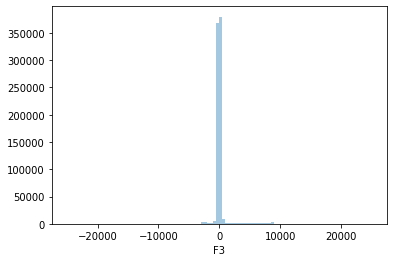

In [50]:
#for c in df.columns:
#    if c != "State":
c = "F3"
sns.distplot(df[  (25*-10**3 < df[c]) & (df[c] < 25*10**3)  ][c], bins = 100, kde = False)

In [58]:
df[(df[:] < 10) & (df[:] > -10)].dropna()

,F3,F4,AF3,AF4,C5,C6,C3,C4,C1,C2,P3,P4,P5,P6,Fz,Cz,State
153,9.406839,8.452053,-5.299081,-5.259904,-5.106271,3.972665,-0.600906,9.308547,-7.123870,3.727278,2.859825,-3.913985,2.507466,-0.176689,1.533047,8.219534,1
304,-0.333133,1.552356,5.032866,-0.804239,8.621657,-1.410604,-7.062814,-5.138879,-2.914448,-4.706720,-2.115576,-2.872929,-5.068846,-4.952340,-3.745790,0.697639,1
342,0.741023,3.260705,1.584166,-1.392299,-9.104962,8.069936,-0.784571,-2.880644,7.321112,-4.282633,1.277624,2.908548,-4.588328,-1.307697,2.335273,7.772311,0
458,8.289840,1.411312,8.066443,0.338103,6.210937,-6.731769,-0.314851,2.132537,4.277757,-1.733068,-1.277740,3.259567,0.357081,6.002818,0.293218,-4.532141,1
485,5.543864,-1.952965,2.358212,1.986539,3.020465,2.297071,2.061364,2.057830,-0.119029,-5.487216,-0.838719,2.925521,2.453323,-2.420426,-1.588564,-4.719428,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809690,-5.197818,-5.000859,2.187647,0.664956,0.906984,4.168694,-0.654641,7.046252,1.528835,0.429879,1.457470,-5.358037,6.939126,0.412190,-0.568364,0.091066,1
809703,-6.166059,-0.542296,3.645586,-1.612211,0.383361,0.884789,0.807395,-0.913879,1.885833,-2.683769,2.037240,3.245499,6.163919,3.332222,9.894668,4.090099,1
809704,2.090639,0.482049,-5.961883,7.072495,-4.181207,3.224622,7.322514,3.917969,0.139972,9.305531,3.046902,9.620210,3.393731,1.756014,4.886458,1.922091,1
809721,-5.462392,3.845842,1.251437,3.337443,-1.445976,-6.316340,-6.962024,1.716982,-3.415689,-5.816917,3.001545,-3.732874,-6.272745,-2.286428,-1.700766,-0.956887,0


In [74]:
df['State']

0         0
1         1
2         1
3         0
4         0
         ..
280315    0
280316    1
280317    1
280318    0
280319    1
Name: State, Length: 280320, dtype: int64

In [64]:
#Teste Especificidade
resul = testePorTrecho(modelo, 10, 3, freq = 512, vRange = 1000, cols=["C5", "C6", "C3", "C4", "C1", "C2", "Cz"])

Arquivo 11 não existe
122324 e 122324


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.3s


61440
61952
62464
62976
63488
64000
64512
65024
65536
66048
66560
67072
67584
68096
68608
69120
69632
70144
70656
71168
71680
72192
72704
73216
73728
74240
74752
75264
75776
76288
76800
77312
77824
78336
78848
79360
79872
80384
80896
81408
81920
82432
82944
83456
83968
84480
84992
85504
86016
86528
87040
87552
88064
88576
89088
89600
90112
90624
91136
91648
92160
92672
93184
93696
94208
94720
95232
95744
96256
96768
97280
97792
98304
98816
99328
99840
100352
100864
101376
101888
102400
102912
103424
103936
104448
104960
105472
105984
106496
107008
107520
108032
108544
109056
109568
110080
110592
111104
111616
112128
112640
113152
113664
114176
114688
115200
115712
116224
116736
117248
117760
118272
118784
119296
119808
120320
120832
121344
121856


[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.6s finished
C:\Users\Pedro\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Pedro\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [58]:
nice = 0
qtd = 0

for item in resul:
    qtd += 1
    
    if item[0] >= 0.5:
        nice += 1
        
print(len(resul) - qtd)
print(nice / qtd)

0
0.502092050209205


In [50]:
len(resul)

239

In [60]:
resul

[array([0.515625, 0.484375]),
 array([0.52773438, 0.47226563]),
 array([0.52902344, 0.47097656]),
 array([0.51746094, 0.48253906]),
 array([0.53203125, 0.46796875]),
 array([0.50753906, 0.49246094]),
 array([0.51042969, 0.48957031]),
 array([0.53125, 0.46875]),
 array([0.50554688, 0.49445313]),
 array([0.50085938, 0.49914062]),
 array([0.53351563, 0.46648438]),
 array([0.52121094, 0.47878906]),
 array([0.52125, 0.47875]),
 array([0.51789062, 0.48210938]),
 array([0.52082031, 0.47917969]),
 array([0.50863281, 0.49136719]),
 array([0.53011719, 0.46988281]),
 array([0.51492187, 0.48507813]),
 array([0.51183594, 0.48816406]),
 array([0.50933594, 0.49066406]),
 array([0.52242188, 0.47757812]),
 array([0.52183594, 0.47816406]),
 array([0.52144531, 0.47855469]),
 array([0.51847656, 0.48152344]),
 array([0.51453125, 0.48546875]),
 array([0.53363281, 0.46636719]),
 array([0.52542969, 0.47457031]),
 array([0.51367188, 0.48632812]),
 array([0.50363281, 0.49636719]),
 array([0.520625, 0.479375]),
